# Setup

In [ ]:
from google.colab import drive
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Pipeline


In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:

file_path = "/content/drive/MyDrive/24fall_dlProject/data/BTC-USD_stock_data.csv"

data = pd.read_csv(file_path,index_col='Date',parse_dates=['Date'])
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,998.325012,147775008
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,1021.750000,222184992
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,1154.729980,344945984
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,1013.380005,510199008


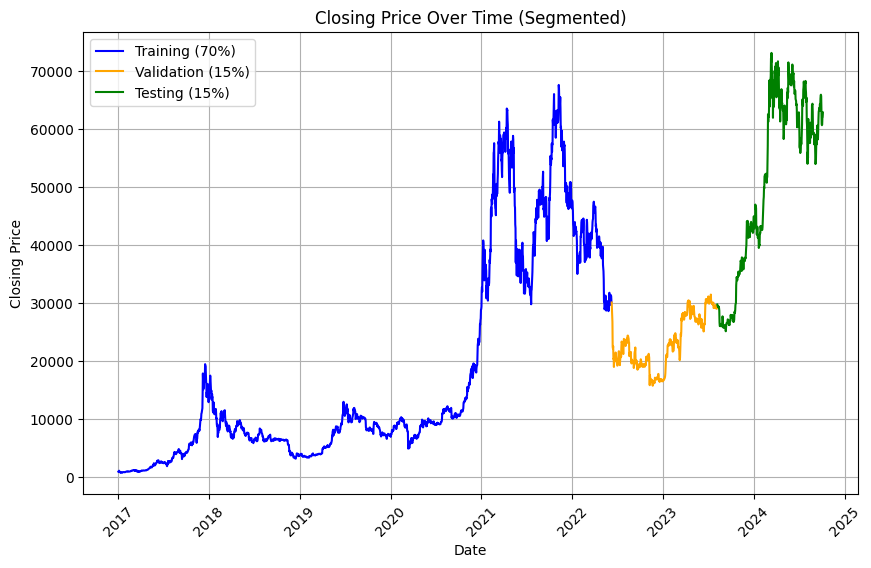

In [ ]:
close_data = data['Close'].values  # Get 'Close' data as a NumPy array
total_data_points = len(close_data)
segment1_end = int(total_data_points * 0.7)
segment2_end = int(total_data_points * (0.7 + 0.15))

plt.figure(figsize=(10, 6))

# Plotting segments with different colors
plt.plot(data.index[:segment1_end], close_data[:segment1_end], label='Training (70%)', color='blue')
plt.plot(data.index[segment1_end:segment2_end], close_data[segment1_end:segment2_end], label='Validation (15%)', color='orange')
plt.plot(data.index[segment2_end:], close_data[segment2_end:], label='Testing (15%)', color='green')

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Closing Price Over Time (Segmented)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [ ]:
def data_preprocessing_with_closed_price_and_min_max_scaler(data, seq_length=60):
    train_ratio = 0.7
    val_ratio = 0.15
    new_data = data.drop(columns=["Adj Close"])
    close_data = new_data.values.reshape(2836, 5)
    scaler = MinMaxScaler(feature_range=(0, 10))
    data_scaled = scaler.fit_transform(close_data)
    data_scaled = pd.DataFrame(data_scaled)

    def create_feature_datasets(data, x_size):
        x_datasets = []
        y_datasets = []
        for i in range(len(data) - x_size):
            x = data[i:i + x_size].values.reshape(-1, 5)
            y = data[i + x_size:i + x_size + 1][3].values.reshape(1)
            x_datasets.append(x)
            y_datasets.append(y)
        X = np.array(x_datasets)
        y = np.array(y_datasets)
        X_train =  X[:int(len(X) * train_ratio)]
        y_train = y[:int(len(y) * train_ratio)]
        X_val = X[int(len(X) * train_ratio):int(len(X) * (train_ratio + val_ratio))]
        y_val = y[int(len(y) * train_ratio):int(len(y) * (train_ratio + val_ratio))]
        X_test = X[int(len(X) * (train_ratio + val_ratio)):]
        y_test = y[int(len(y) * (train_ratio + val_ratio)):]

        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]

        return torch.Tensor(X_train_shuffled).to(device), torch.Tensor(X_val).to(device), torch.Tensor(X_test).to(device), torch.Tensor(y_train_shuffled).to(device), torch.Tensor(y_val).to(device), torch.Tensor(y_test).to(device)

    return create_feature_datasets(data_scaled, seq_length), scaler

(X_train, X_val, X_test, y_train, y_val, y_test), min_max_scaler = data_preprocessing_with_closed_price_and_min_max_scaler(data, 60)

# Baseline Model

In [ ]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)  # Initial hidden state
        c_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)  # Initial cell state
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])  # Get the output from the last time step
        return out

# Training

In [ ]:
# create a nn class (just-for-fun choice :-)
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [ ]:
# Hyperparameters
input_size = 5
hidden_size = 128
num_layers = 2
dropout = 0.1
output_size = 1


learning_rate = 0.00001
num_epochs = 200
batch_size = 4

# Create dataset and DataLoader for batching
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model, loss, optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout)
model.to(device)
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

epoch_losses = []

# Training loop with batching
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (batch_x, batch_y) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    epoch_losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/200], Loss: 0.0462
Epoch [20/200], Loss: 0.1419
Epoch [30/200], Loss: 0.2365
Epoch [40/200], Loss: 0.2143
Epoch [50/200], Loss: 0.2248
Epoch [60/200], Loss: 0.0899
Epoch [70/200], Loss: 0.0847
Epoch [80/200], Loss: 0.0277
Epoch [90/200], Loss: 0.1312
Epoch [100/200], Loss: 0.1601
Epoch [110/200], Loss: 0.0451
Epoch [120/200], Loss: 0.0541
Epoch [130/200], Loss: 0.1923
Epoch [140/200], Loss: 0.0194
Epoch [150/200], Loss: 0.1578
Epoch [160/200], Loss: 0.3986
Epoch [170/200], Loss: 0.0472
Epoch [180/200], Loss: 0.0498
Epoch [190/200], Loss: 0.0398
Epoch [200/200], Loss: 0.0645


# Visualization

In [ ]:
model.eval()
with torch.no_grad():
    predictions = model(X_train)
    print(f'Predicted value for the first sample: {predictions[0].item():.4f}')

y_train.to(device)
rmse = torch.sqrt(torch.mean((predictions - y_train) ** 2))
print(f"Training Loss Scaling Unreversed: {rmse.item()}")

if device == torch.device("cuda"):
    predictions_cpu = predictions.cpu()
    y_train_cpu = y_train.cpu()

# Reverse the scaling
predictions_reversed = torch.Tensor(min_max_scaler.inverse_transform(np.repeat(predictions_cpu.numpy(), 5, axis=1)))[:, 3]
y_train_reversed = torch.Tensor(min_max_scaler.inverse_transform(np.repeat(y_train_cpu.numpy(), 5, axis=1)))[:, 3]
rmse_reversed = torch.sqrt(torch.mean((predictions_reversed - y_train_reversed) ** 2))
print(f"Training Loss Scaling Reversed: {rmse_reversed.item()}")

Predicted value for the first sample: 2.4821
Training Loss Scaling Unreversed: 0.1488981693983078
Training Loss Scaling Reversed: 1076.6192626953125


In [ ]:
model.eval()
with torch.no_grad():
    predictions = model(X_val)
    print(f'Predicted value for the first sample: {predictions[0].item():.4f}')
rmse = torch.sqrt(torch.mean((predictions - y_val) ** 2))
print(f"Validation Loss Scaling Unreversed: {rmse.item()}")

if device == torch.device("cuda"):
    predictions_cpu = predictions.cpu()
    y_val_cpu = y_val.cpu()

# Reverse the scaling
predictions_reversed = torch.Tensor(min_max_scaler.inverse_transform(np.repeat(predictions_cpu.numpy(), 5, axis=1)))[:, 3]
y_val_reversed = torch.Tensor(min_max_scaler.inverse_transform(np.repeat(y_val_cpu.numpy(), 5, axis=1)))[:, 3]
rmse_reversed = torch.sqrt(torch.mean((predictions_reversed - y_val_reversed) ** 2))
print(f"Validation Loss Scaling Reversed: {rmse_reversed.item()}")

Predicted value for the first sample: 2.9130
Validation Loss Scaling Unreversed: 0.10480472445487976
Validation Loss Scaling Reversed: 757.7982788085938


In [ ]:
def calculate_daily_long_trade_return_percentage(predicted_prices, true_prices):
  def generate_daily_trade_signals_long_only(predicted_prices, true_prices):
    signals = torch.zeros_like(predicted_prices)
    # Ensure signals and predicted_prices have compatible shapes for comparison
    signals[:-1] = torch.where(predicted_prices[1:] > predicted_prices[:-1], 1, 0)  # Buy if tomorrow's predicted price > today's
    return signals

  # Trim predicted_prices to match the length of true_prices - 1
  predicted_prices = predicted_prices[:len(true_prices) - 1]  # This ensures both have same dimension for comparison

  signals = generate_daily_trade_signals_long_only(predicted_prices, true_prices)

  # Calculate price differences and percentage change
  price_diff = true_prices[1:] - true_prices[:-1]
  percentage_returns = (price_diff / true_prices[:-1])  # Convert to percentage change

  # Ensure both signal and percentage_returns have the same shape before multiplication
  # This addresses the issue by removing the last element from signals
  returns = signals[:-1] * percentage_returns[:-1]  # Both now have length 414

  # Step 1: Calculate cumulative returns
  cumulative_returns = torch.cumprod(1 + returns, dim=0)

  # Step 2: Calculate running maximum of cumulative returns
  running_max, _ = torch.cummax(cumulative_returns, dim=0)

  # Step 3: Calculate drawdowns
  drawdowns = (cumulative_returns - running_max) / running_max

  # Step 4: Find the maximum drawdown
  max_drawdown = drawdowns.min()

  print("Return:", cumulative_returns[-1].item() - 1)
  print("Max Drawdown:", max_drawdown.item())

In [ ]:
# Example usage:
predicted_prices = predictions_reversed.view(-1)
true_prices = y_val_reversed.view(-1)

calculate_daily_long_trade_return_percentage(predicted_prices, true_prices)

Return: 0.0952298641204834
Max Drawdown: -0.23061536252498627


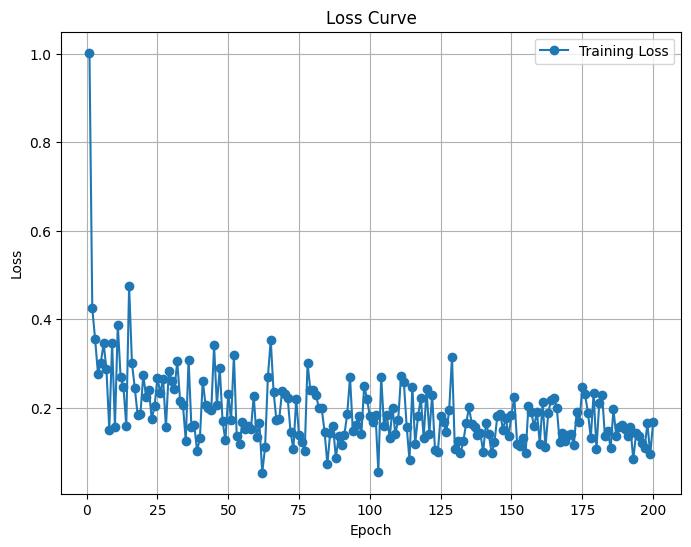

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.show()

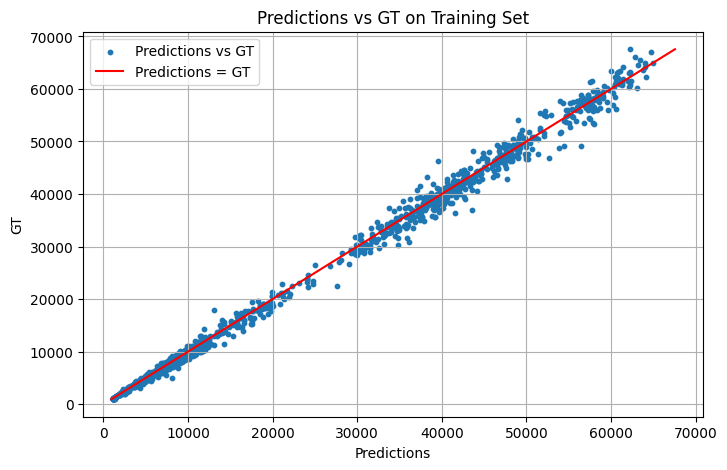

In [ ]:

# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_train_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.scatter(tensor1.numpy(), tensor2.numpy(), label='Predictions vs GT', marker='o', s=10)

min_val = min(tensor1.min(), tensor2.min())
max_val = max(tensor1.max(), tensor2.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='-', label='Predictions = GT')

plt.title('Predictions vs GT on Training Set')
plt.xlabel('Predictions')
plt.ylabel('GT')
plt.legend()
plt.grid(True)
plt.show()

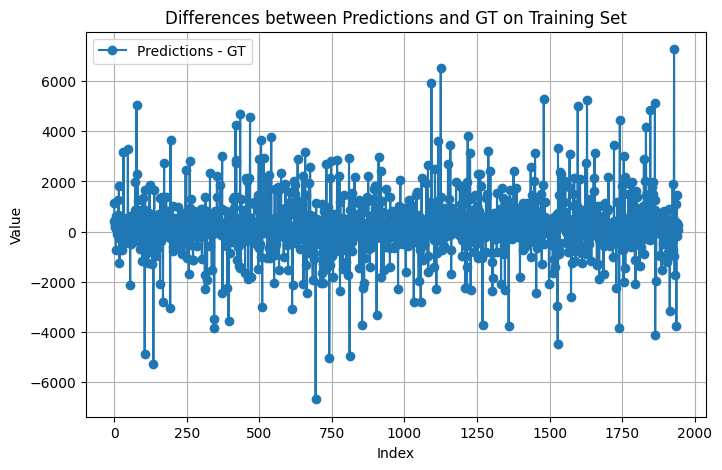

In [ ]:
# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_train_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.plot(tensor1.numpy() - tensor2.numpy(), label='Predictions - GT', marker='o')
plt.title('Differences between Predictions and GT on Training Set')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

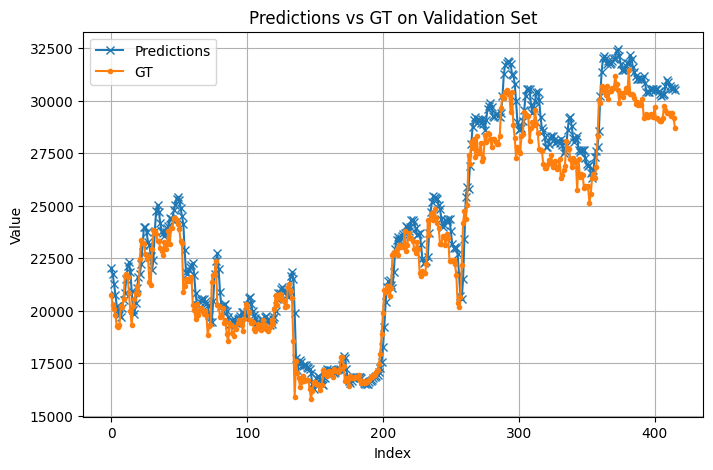

In [ ]:
# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_val_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.plot(tensor1.numpy(), label='Predictions', marker='x')
plt.plot(tensor2.numpy(), label='GT', marker='.')
plt.title('Predictions vs GT on Validation Set')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

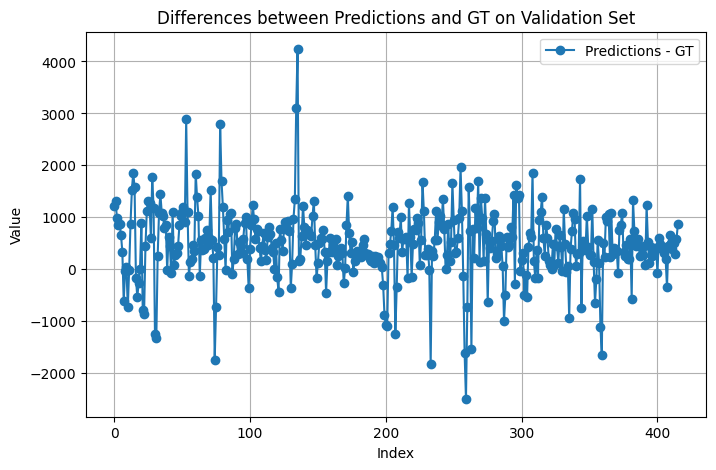

In [ ]:
# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_val_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.plot(tensor1.numpy() - tensor2.numpy(), label='Predictions - GT', marker='o')
plt.title('Differences between Predictions and GT on Validation Set')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Return

In [ ]:
def calculate_daily_short_trade_return_percentage(predicted_prices, true_prices):
  def generate_daily_trade_signals_short_only(predicted_prices, true_prices):
    signals = torch.zeros_like(predicted_prices)
    # Generate a short signal (-1) if tomorrow's predicted price is lower than today's predicted price
    signals[:-1] = torch.where(predicted_prices[1:] < predicted_prices[:-1], 1, 0)
    return signals

  signals = generate_daily_trade_signals_short_only(predicted_prices, true_prices)

  # Calculate price differences and percentage change
  price_diff = true_prices[:-1] - true_prices[1:]  # Since this is a short trade, we reverse the diff
  percentage_returns = (price_diff / true_prices[:-1])  # Convert to percentage change
  # Calculate returns based on signals
  returns = signals[:-1] * percentage_returns
  # Step 1: Calculate cumulative returns
  cumulative_returns = torch.cumprod(1 + returns, dim=0)

  # Step 2: Calculate running maximum of cumulative returns
  running_max, _ = torch.cummax(cumulative_returns, dim=0)

  # Step 3: Calculate drawdowns
  drawdowns = (cumulative_returns - running_max) / running_max

  # Step 4: Find the maximum drawdown
  max_drawdown = drawdowns.min()

  print("Return:", cumulative_returns[-1].item() - 1)
  print("Max Drawdown:", max_drawdown.item())

In [ ]:
# Example usage:
predicted_prices = predictions_reversed.view(-1)
true_prices = y_val_reversed.view(-1)

calculate_daily_short_trade_return_percentage(predicted_prices, true_prices)

Return: -0.12636137008666992
Max Drawdown: -0.401183545589447
